# Initialize

In [1]:
#@title Import {display-mode: "form"}
import math
import torch
from torch import nn

# Model

In [2]:
#@title Swish {display-mode: "form"}
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [3]:
#@title FeatureEx1d {display-mode: "form"}
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [4]:
#@title SEblock {display-mode: "form"}
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [5]:
#@title ConvBNFirst {display-mode: "form"}
class ConvBNFirst(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size=(3, 257), stride=(1, 257), padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [6]:
#@title ConvBN {display-mode: "form"}
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [7]:
#@title DropConnect {display-mode: "form"}
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [8]:
#@title BMConvBlock {display-mode: "form"}
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=0, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [9]:
#@title Flatten {display-mode: "form"}
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [10]:
#@title LSTM {display-mode: "form"}
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size=128):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = x.permute(2,0,1,3)
        x = x.squeeze(dim=3)
        _, lstm_out = self.lstm(x)
        x = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
        return x

In [11]:
#@title MultiModalNet {display-mode: "form"}
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=2.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_1d_features=10,
               num_classes=4,
               input_ch=3):
    super().__init__()
    features = [BMConvBlock(input_ch, 512, expand_ratio=6, stride=(1,257), kernel_size=(3, 257))]


    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        LSTMClassifier(embedding_dim=512, hidden_dim=512)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

    self.features1d = nn.Sequential(
        nn.Linear(num_1d_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features1d(x[0])
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)

    return x

# Dataset

In [12]:
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"

In [13]:
import shutil
import os


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/" + dirs, data_dir + dirs)

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"  + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = data_dir + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

Q1 9200
Q2 9200
Q3 9200
Q4 9200
Q1 9200
Q2 9200
Q3 9200
Q4 9200


In [14]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)


      for f in file_list:
        split_num = int(f.split(".")[1].split("_")[-1])
        if split_num % 5 == 4:
          valid_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))
        else:
          train_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))

  
  return train_file_list, valid_file_list


In [15]:
from torch.utils import data
import numpy as np
import librosa
import pickle
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)


  def __getitem__(self, index):
    pickle_path = self.file_list[index]
    x,y = pickle.load(open(pickle_path, mode="rb"))
    return x, y


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset1 shape:", train_dataset.__getitem__(index)[0][0].size())
print("Dataset2 shape:", train_dataset.__getitem__(index)[0][1].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  29600
/content/datas/Q3/Q3.MT0011398970_45.wav.pickle
検証データ数 :  7200
/content/datas/Q3/Q3.MT0007349999_14.wav.pickle
Dataset1 shape: torch.Size([26])
Dataset2 shape: torch.Size([1, 431, 257])
Dataset label: 2


# DataLoader

In [16]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs[0].size())
print(inputs[1].size())
print(labels)


torch.Size([64, 26])
torch.Size([64, 1, 431, 257])
tensor([3, 1, 1, 0, 2, 3, 3, 0, 3, 1, 1, 2, 3, 2, 3, 2, 2, 0, 2, 1, 1, 0, 1, 2,
        2, 2, 1, 2, 0, 2, 3, 2, 2, 0, 1, 3, 1, 2, 0, 0, 2, 0, 2, 3, 1, 3, 0, 2,
        3, 2, 0, 0, 1, 1, 3, 1, 1, 3, 0, 3, 3, 2, 3, 2])


# Optimizer, Criterion

In [17]:
torch_clearlizer = False #@param {type: "boolean"}

if torch_clearlizer:
  del train_dataset
  del valid_dataset
  del train_dataloader
  del valid_dataloader
  del labels
  del loss_hist
  del acc_hist
  del optimizer
  del criterion
  torch.cuda.empty_cache()

In [18]:
from torch import optim

model     = MultiModalNet(input_ch=1, num_classes=4, num_1d_features=train_dataset.__getitem__(index)[0][0].size(0)).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.1) 
criterion = nn.CrossEntropyLoss()

SGD -> じわっとloss減ってく


# Training

In [19]:
from tqdm import tqdm
# エポック数
num_epochs = 200


loss_hist = [[],[]]
acc_hist = [[],[]]

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-------------')
  
  for phase in ['train', 'valid']:
      
    if phase == 'train':
      # モデルを訓練モードに設定
      model.train()
    else:
      # モデルを推論モードに設定
      model.eval()
    
    # 損失和
    epoch_loss = 0.0
    # 正解数
    epoch_corrects = 0
    
    # DataLoaderからデータをバッチごとに取り出す
    with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
      pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
      for inputs, labels in pbar:
        inputs = [inputs[0].to('cuda') , inputs[1].to('cuda')]
        labels = labels.to('cuda')
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          
          # 損失を計算
          loss = criterion(outputs, labels)
          
          # ラベルを予測
          _, preds = torch.max(outputs, 1)
          
          # 訓練時はバックプロパゲーション
          if phase == 'train':
            # 逆伝搬の計算
            loss.backward()
            # パラメータの更新
            optimizer.step()
          
          # イテレーション結果の計算
          # lossの合計を更新
          # PyTorchの仕様上各バッチ内での平均のlossが計算される。
          # データ数を掛けることで平均から合計に変換をしている。
          # 損失和は「全データの損失/データ数」で計算されるため、
          # 平均のままだと損失和を求めることができないため。
          l = loss.item()
          epoch_loss += l * inputs[0].size(0)
          pbar.set_postfix(dict(loss=l))

          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
    acc_hist[0].append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

    print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=1.2]


[train] Epoch 1 Result: Loss: 1.3043 Acc: 0.4027



[valid] Epoch 1: 100%|██████████| 113/113 [00:29<00:00,  3.85batch/s, loss=1.07]


[valid] Epoch 1 Result: Loss: 1.2239 Acc: 0.4713

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=1.1]


[train] Epoch 2 Result: Loss: 1.1808 Acc: 0.5388



[valid] Epoch 2: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=1.03]


[valid] Epoch 2 Result: Loss: 1.1436 Acc: 0.5797

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=1.12]


[train] Epoch 3 Result: Loss: 1.1219 Acc: 0.6151



[valid] Epoch 3: 100%|██████████| 113/113 [00:27<00:00,  4.12batch/s, loss=1.27]


[valid] Epoch 3 Result: Loss: 1.1041 Acc: 0.6275

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=1.03]


[train] Epoch 4 Result: Loss: 1.0879 Acc: 0.6505



[valid] Epoch 4: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.973]


[valid] Epoch 4 Result: Loss: 1.0720 Acc: 0.6675

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=1.03]


[train] Epoch 5 Result: Loss: 1.0575 Acc: 0.6842



[valid] Epoch 5: 100%|██████████| 113/113 [00:27<00:00,  4.05batch/s, loss=0.915]


[valid] Epoch 5 Result: Loss: 1.0495 Acc: 0.6911

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=1.16]


[train] Epoch 6 Result: Loss: 1.0305 Acc: 0.7124



[valid] Epoch 6: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.904]


[valid] Epoch 6 Result: Loss: 1.0173 Acc: 0.7268

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=1.03]


[train] Epoch 7 Result: Loss: 1.0066 Acc: 0.7360



[valid] Epoch 7: 100%|██████████| 113/113 [00:28<00:00,  3.99batch/s, loss=0.907]


[valid] Epoch 7 Result: Loss: 0.9860 Acc: 0.7596

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.953]


[train] Epoch 8 Result: Loss: 0.9842 Acc: 0.7590



[valid] Epoch 8: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.874]


[valid] Epoch 8 Result: Loss: 0.9634 Acc: 0.7806

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=1.11]


[train] Epoch 9 Result: Loss: 0.9619 Acc: 0.7823



[valid] Epoch 9: 100%|██████████| 113/113 [00:28<00:00,  4.02batch/s, loss=0.843]


[valid] Epoch 9 Result: Loss: 0.9808 Acc: 0.7621

Epoch 10/200
-------------


[train] Epoch 10: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.883]


[train] Epoch 10 Result: Loss: 0.9473 Acc: 0.7961



[valid] Epoch 10: 100%|██████████| 113/113 [00:27<00:00,  4.07batch/s, loss=0.894]


[valid] Epoch 10 Result: Loss: 0.9348 Acc: 0.8085

Epoch 11/200
-------------


[train] Epoch 11: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.844]


[train] Epoch 11 Result: Loss: 0.9292 Acc: 0.8152



[valid] Epoch 11: 100%|██████████| 113/113 [00:27<00:00,  4.15batch/s, loss=0.879]


[valid] Epoch 11 Result: Loss: 0.9157 Acc: 0.8300

Epoch 12/200
-------------


[train] Epoch 12: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.859]


[train] Epoch 12 Result: Loss: 0.9157 Acc: 0.8294



[valid] Epoch 12: 100%|██████████| 113/113 [00:27<00:00,  4.10batch/s, loss=0.807]


[valid] Epoch 12 Result: Loss: 0.9363 Acc: 0.8042

Epoch 13/200
-------------


[train] Epoch 13: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.927]


[train] Epoch 13 Result: Loss: 0.9043 Acc: 0.8388



[valid] Epoch 13: 100%|██████████| 113/113 [00:27<00:00,  4.13batch/s, loss=0.904]


[valid] Epoch 13 Result: Loss: 0.8989 Acc: 0.8450

Epoch 14/200
-------------


[train] Epoch 14: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.885]


[train] Epoch 14 Result: Loss: 0.8945 Acc: 0.8492



[valid] Epoch 14: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.821]


[valid] Epoch 14 Result: Loss: 0.8934 Acc: 0.8499

Epoch 15/200
-------------


[train] Epoch 15: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=1.07]


[train] Epoch 15 Result: Loss: 0.8815 Acc: 0.8629



[valid] Epoch 15: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=0.983]


[valid] Epoch 15 Result: Loss: 0.9027 Acc: 0.8393

Epoch 16/200
-------------


[train] Epoch 16: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.795]


[train] Epoch 16 Result: Loss: 0.8727 Acc: 0.8711



[valid] Epoch 16: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.849]


[valid] Epoch 16 Result: Loss: 0.8765 Acc: 0.8667

Epoch 17/200
-------------


[train] Epoch 17: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.874]


[train] Epoch 17 Result: Loss: 0.8651 Acc: 0.8792



[valid] Epoch 17: 100%|██████████| 113/113 [00:28<00:00,  3.95batch/s, loss=0.805]


[valid] Epoch 17 Result: Loss: 0.8622 Acc: 0.8824

Epoch 18/200
-------------


[train] Epoch 18: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.91]


[train] Epoch 18 Result: Loss: 0.8577 Acc: 0.8870



[valid] Epoch 18: 100%|██████████| 113/113 [00:28<00:00,  3.95batch/s, loss=0.826]


[valid] Epoch 18 Result: Loss: 0.9121 Acc: 0.8300

Epoch 19/200
-------------


[train] Epoch 19: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.751]


[train] Epoch 19 Result: Loss: 0.8551 Acc: 0.8882



[valid] Epoch 19: 100%|██████████| 113/113 [00:27<00:00,  4.04batch/s, loss=0.806]


[valid] Epoch 19 Result: Loss: 0.8462 Acc: 0.8972

Epoch 20/200
-------------


[train] Epoch 20: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.867]


[train] Epoch 20 Result: Loss: 0.8484 Acc: 0.8951



[valid] Epoch 20: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.806]


[valid] Epoch 20 Result: Loss: 0.8420 Acc: 0.9012

Epoch 21/200
-------------


[train] Epoch 21: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.793]


[train] Epoch 21 Result: Loss: 0.8406 Acc: 0.9032



[valid] Epoch 21: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.814]


[valid] Epoch 21 Result: Loss: 0.8397 Acc: 0.9040

Epoch 22/200
-------------


[train] Epoch 22: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.85]


[train] Epoch 22 Result: Loss: 0.8362 Acc: 0.9081



[valid] Epoch 22: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.805]


[valid] Epoch 22 Result: Loss: 0.8548 Acc: 0.8889

Epoch 23/200
-------------


[train] Epoch 23: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.838]


[train] Epoch 23 Result: Loss: 0.8306 Acc: 0.9136



[valid] Epoch 23: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.806]


[valid] Epoch 23 Result: Loss: 0.8239 Acc: 0.9194

Epoch 24/200
-------------


[train] Epoch 24: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.776]


[train] Epoch 24 Result: Loss: 0.8283 Acc: 0.9161



[valid] Epoch 24: 100%|██████████| 113/113 [00:28<00:00,  4.00batch/s, loss=0.806]


[valid] Epoch 24 Result: Loss: 0.8258 Acc: 0.9190

Epoch 25/200
-------------


[train] Epoch 25: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.864]


[train] Epoch 25 Result: Loss: 0.8239 Acc: 0.9203



[valid] Epoch 25: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.836]


[valid] Epoch 25 Result: Loss: 0.8373 Acc: 0.9081

Epoch 26/200
-------------


[train] Epoch 26: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.961]


[train] Epoch 26 Result: Loss: 0.8295 Acc: 0.9141



[valid] Epoch 26: 100%|██████████| 113/113 [00:29<00:00,  3.89batch/s, loss=0.805]


[valid] Epoch 26 Result: Loss: 0.8253 Acc: 0.9176

Epoch 27/200
-------------


[train] Epoch 27: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.778]


[train] Epoch 27 Result: Loss: 0.8192 Acc: 0.9251



[valid] Epoch 27: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.805]


[valid] Epoch 27 Result: Loss: 0.8218 Acc: 0.9229

Epoch 28/200
-------------


[train] Epoch 28: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.842]


[train] Epoch 28 Result: Loss: 0.8174 Acc: 0.9271



[valid] Epoch 28: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=0.804]


[valid] Epoch 28 Result: Loss: 0.8154 Acc: 0.9278

Epoch 29/200
-------------


[train] Epoch 29: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.776]


[train] Epoch 29 Result: Loss: 0.8141 Acc: 0.9302



[valid] Epoch 29: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.803]


[valid] Epoch 29 Result: Loss: 0.8127 Acc: 0.9315

Epoch 30/200
-------------


[train] Epoch 30: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.801]


[train] Epoch 30 Result: Loss: 0.8100 Acc: 0.9341



[valid] Epoch 30: 100%|██████████| 113/113 [00:28<00:00,  3.90batch/s, loss=0.831]


[valid] Epoch 30 Result: Loss: 0.8469 Acc: 0.8947

Epoch 31/200
-------------


[train] Epoch 31: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.813]


[train] Epoch 31 Result: Loss: 0.8082 Acc: 0.9359



[valid] Epoch 31: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.829]


[valid] Epoch 31 Result: Loss: 0.8104 Acc: 0.9335

Epoch 32/200
-------------


[train] Epoch 32: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.838]


[train] Epoch 32 Result: Loss: 0.8048 Acc: 0.9394



[valid] Epoch 32: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.814]


[valid] Epoch 32 Result: Loss: 0.8082 Acc: 0.9363

Epoch 33/200
-------------


[train] Epoch 33: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 33 Result: Loss: 0.8030 Acc: 0.9411



[valid] Epoch 33: 100%|██████████| 113/113 [00:28<00:00,  4.00batch/s, loss=0.806]


[valid] Epoch 33 Result: Loss: 0.7984 Acc: 0.9447

Epoch 34/200
-------------


[train] Epoch 34: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.792]


[train] Epoch 34 Result: Loss: 0.8014 Acc: 0.9422



[valid] Epoch 34: 100%|██████████| 113/113 [00:27<00:00,  4.05batch/s, loss=0.806]


[valid] Epoch 34 Result: Loss: 0.8349 Acc: 0.9060

Epoch 35/200
-------------


[train] Epoch 35: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.837]


[train] Epoch 35 Result: Loss: 0.8012 Acc: 0.9428



[valid] Epoch 35: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.805]


[valid] Epoch 35 Result: Loss: 0.7981 Acc: 0.9453

Epoch 36/200
-------------


[train] Epoch 36: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.785]


[train] Epoch 36 Result: Loss: 0.7978 Acc: 0.9462



[valid] Epoch 36: 100%|██████████| 113/113 [00:28<00:00,  3.93batch/s, loss=0.804]


[valid] Epoch 36 Result: Loss: 0.7963 Acc: 0.9479

Epoch 37/200
-------------


[train] Epoch 37: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 37 Result: Loss: 0.7973 Acc: 0.9467



[valid] Epoch 37: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.804]


[valid] Epoch 37 Result: Loss: 0.7974 Acc: 0.9471

Epoch 38/200
-------------


[train] Epoch 38: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.812]


[train] Epoch 38 Result: Loss: 0.7955 Acc: 0.9484



[valid] Epoch 38: 100%|██████████| 113/113 [00:28<00:00,  3.95batch/s, loss=0.811]


[valid] Epoch 38 Result: Loss: 0.8076 Acc: 0.9363

Epoch 39/200
-------------


[train] Epoch 39: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.918]


[train] Epoch 39 Result: Loss: 0.7941 Acc: 0.9497



[valid] Epoch 39: 100%|██████████| 113/113 [00:28<00:00,  3.99batch/s, loss=0.804]


[valid] Epoch 39 Result: Loss: 0.8201 Acc: 0.9229

Epoch 40/200
-------------


[train] Epoch 40: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.835]


[train] Epoch 40 Result: Loss: 0.7928 Acc: 0.9509



[valid] Epoch 40: 100%|██████████| 113/113 [00:28<00:00,  3.95batch/s, loss=0.804]


[valid] Epoch 40 Result: Loss: 0.7915 Acc: 0.9519

Epoch 41/200
-------------


[train] Epoch 41: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.804]


[train] Epoch 41 Result: Loss: 0.7900 Acc: 0.9541



[valid] Epoch 41: 100%|██████████| 113/113 [00:27<00:00,  4.07batch/s, loss=0.804]


[valid] Epoch 41 Result: Loss: 0.7909 Acc: 0.9532

Epoch 42/200
-------------


[train] Epoch 42: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 42 Result: Loss: 0.7901 Acc: 0.9539



[valid] Epoch 42: 100%|██████████| 113/113 [00:28<00:00,  4.00batch/s, loss=0.805]


[valid] Epoch 42 Result: Loss: 0.7921 Acc: 0.9518

Epoch 43/200
-------------


[train] Epoch 43: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.805]


[train] Epoch 43 Result: Loss: 0.7893 Acc: 0.9544



[valid] Epoch 43: 100%|██████████| 113/113 [00:28<00:00,  3.93batch/s, loss=0.802]


[valid] Epoch 43 Result: Loss: 0.7881 Acc: 0.9560

Epoch 44/200
-------------


[train] Epoch 44: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 44 Result: Loss: 0.7899 Acc: 0.9538



[valid] Epoch 44: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.809]


[valid] Epoch 44 Result: Loss: 0.7884 Acc: 0.9557

Epoch 45/200
-------------


[train] Epoch 45: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.837]


[train] Epoch 45 Result: Loss: 0.7869 Acc: 0.9569



[valid] Epoch 45: 100%|██████████| 113/113 [00:29<00:00,  3.87batch/s, loss=0.805]


[valid] Epoch 45 Result: Loss: 0.7903 Acc: 0.9535

Epoch 46/200
-------------


[train] Epoch 46: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.805]


[train] Epoch 46 Result: Loss: 0.7886 Acc: 0.9554



[valid] Epoch 46: 100%|██████████| 113/113 [00:27<00:00,  4.10batch/s, loss=0.804]


[valid] Epoch 46 Result: Loss: 0.7928 Acc: 0.9508

Epoch 47/200
-------------


[train] Epoch 47: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.778]


[train] Epoch 47 Result: Loss: 0.7858 Acc: 0.9581



[valid] Epoch 47: 100%|██████████| 113/113 [00:27<00:00,  4.09batch/s, loss=0.807]


[valid] Epoch 47 Result: Loss: 0.7853 Acc: 0.9589

Epoch 48/200
-------------


[train] Epoch 48: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.811]


[train] Epoch 48 Result: Loss: 0.7844 Acc: 0.9592



[valid] Epoch 48: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.802]


[valid] Epoch 48 Result: Loss: 0.7885 Acc: 0.9550

Epoch 49/200
-------------


[train] Epoch 49: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 49 Result: Loss: 0.7852 Acc: 0.9584



[valid] Epoch 49: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.804]


[valid] Epoch 49 Result: Loss: 0.7894 Acc: 0.9547

Epoch 50/200
-------------


[train] Epoch 50: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 50 Result: Loss: 0.7831 Acc: 0.9604



[valid] Epoch 50: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.804]


[valid] Epoch 50 Result: Loss: 0.7812 Acc: 0.9622

Epoch 51/200
-------------


[train] Epoch 51: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 51 Result: Loss: 0.7807 Acc: 0.9633



[valid] Epoch 51: 100%|██████████| 113/113 [00:27<00:00,  4.09batch/s, loss=0.803]


[valid] Epoch 51 Result: Loss: 0.7827 Acc: 0.9608

Epoch 52/200
-------------


[train] Epoch 52: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 52 Result: Loss: 0.7804 Acc: 0.9634



[valid] Epoch 52: 100%|██████████| 113/113 [00:26<00:00,  4.25batch/s, loss=0.802]


[valid] Epoch 52 Result: Loss: 0.7789 Acc: 0.9649

Epoch 53/200
-------------


[train] Epoch 53: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.841]


[train] Epoch 53 Result: Loss: 0.7780 Acc: 0.9657



[valid] Epoch 53: 100%|██████████| 113/113 [00:26<00:00,  4.28batch/s, loss=0.802]


[valid] Epoch 53 Result: Loss: 0.7833 Acc: 0.9606

Epoch 54/200
-------------


[train] Epoch 54: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 54 Result: Loss: 0.7778 Acc: 0.9659



[valid] Epoch 54: 100%|██████████| 113/113 [00:27<00:00,  4.06batch/s, loss=0.803]


[valid] Epoch 54 Result: Loss: 0.7785 Acc: 0.9649

Epoch 55/200
-------------


[train] Epoch 55: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 55 Result: Loss: 0.7767 Acc: 0.9669



[valid] Epoch 55: 100%|██████████| 113/113 [00:27<00:00,  4.09batch/s, loss=0.802]


[valid] Epoch 55 Result: Loss: 0.7791 Acc: 0.9651

Epoch 56/200
-------------


[train] Epoch 56: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 56 Result: Loss: 0.7775 Acc: 0.9663



[valid] Epoch 56: 100%|██████████| 113/113 [00:28<00:00,  4.01batch/s, loss=0.803]


[valid] Epoch 56 Result: Loss: 0.7797 Acc: 0.9640

Epoch 57/200
-------------


[train] Epoch 57: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 57 Result: Loss: 0.7762 Acc: 0.9673



[valid] Epoch 57: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.805]


[valid] Epoch 57 Result: Loss: 0.7771 Acc: 0.9665

Epoch 58/200
-------------


[train] Epoch 58: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 58 Result: Loss: 0.7763 Acc: 0.9671



[valid] Epoch 58: 100%|██████████| 113/113 [00:29<00:00,  3.82batch/s, loss=0.803]


[valid] Epoch 58 Result: Loss: 0.7834 Acc: 0.9608

Epoch 59/200
-------------


[train] Epoch 59: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 59 Result: Loss: 0.7769 Acc: 0.9669



[valid] Epoch 59: 100%|██████████| 113/113 [00:29<00:00,  3.84batch/s, loss=0.802]


[valid] Epoch 59 Result: Loss: 0.7779 Acc: 0.9657

Epoch 60/200
-------------


[train] Epoch 60: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 60 Result: Loss: 0.7760 Acc: 0.9677



[valid] Epoch 60: 100%|██████████| 113/113 [00:28<00:00,  3.92batch/s, loss=0.803]


[valid] Epoch 60 Result: Loss: 0.7806 Acc: 0.9632

Epoch 61/200
-------------


[train] Epoch 61: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 61 Result: Loss: 0.7752 Acc: 0.9686



[valid] Epoch 61: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.804]


[valid] Epoch 61 Result: Loss: 0.7760 Acc: 0.9674

Epoch 62/200
-------------


[train] Epoch 62: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 62 Result: Loss: 0.7743 Acc: 0.9693



[valid] Epoch 62: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.803]


[valid] Epoch 62 Result: Loss: 0.7753 Acc: 0.9683

Epoch 63/200
-------------


[train] Epoch 63: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.757]


[train] Epoch 63 Result: Loss: 0.7738 Acc: 0.9698



[valid] Epoch 63: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.802]


[valid] Epoch 63 Result: Loss: 0.7930 Acc: 0.9508

Epoch 64/200
-------------


[train] Epoch 64: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 64 Result: Loss: 0.7745 Acc: 0.9691



[valid] Epoch 64: 100%|██████████| 113/113 [00:28<00:00,  3.99batch/s, loss=0.802]


[valid] Epoch 64 Result: Loss: 0.7768 Acc: 0.9671

Epoch 65/200
-------------


[train] Epoch 65: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.745]


[train] Epoch 65 Result: Loss: 0.7743 Acc: 0.9696



[valid] Epoch 65: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.804]


[valid] Epoch 65 Result: Loss: 0.7758 Acc: 0.9676

Epoch 66/200
-------------


[train] Epoch 66: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.776]


[train] Epoch 66 Result: Loss: 0.7739 Acc: 0.9700



[valid] Epoch 66: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.803]


[valid] Epoch 66 Result: Loss: 0.7747 Acc: 0.9689

Epoch 67/200
-------------


[train] Epoch 67: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 67 Result: Loss: 0.7728 Acc: 0.9710



[valid] Epoch 67: 100%|██████████| 113/113 [00:28<00:00,  3.93batch/s, loss=0.803]


[valid] Epoch 67 Result: Loss: 0.7745 Acc: 0.9693

Epoch 68/200
-------------


[train] Epoch 68: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 68 Result: Loss: 0.7717 Acc: 0.9721



[valid] Epoch 68: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.804]


[valid] Epoch 68 Result: Loss: 0.7727 Acc: 0.9710

Epoch 69/200
-------------


[train] Epoch 69: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 69 Result: Loss: 0.7724 Acc: 0.9712



[valid] Epoch 69: 100%|██████████| 113/113 [00:27<00:00,  4.05batch/s, loss=0.803]


[valid] Epoch 69 Result: Loss: 0.7739 Acc: 0.9703

Epoch 70/200
-------------


[train] Epoch 70: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.834]


[train] Epoch 70 Result: Loss: 0.7708 Acc: 0.9729



[valid] Epoch 70: 100%|██████████| 113/113 [00:28<00:00,  3.92batch/s, loss=0.802]


[valid] Epoch 70 Result: Loss: 0.7733 Acc: 0.9706

Epoch 71/200
-------------


[train] Epoch 71: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 71 Result: Loss: 0.7703 Acc: 0.9735



[valid] Epoch 71: 100%|██████████| 113/113 [00:28<00:00,  3.92batch/s, loss=0.803]


[valid] Epoch 71 Result: Loss: 0.7719 Acc: 0.9717

Epoch 72/200
-------------


[train] Epoch 72: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.775]


[train] Epoch 72 Result: Loss: 0.7682 Acc: 0.9755



[valid] Epoch 72: 100%|██████████| 113/113 [00:28<00:00,  3.93batch/s, loss=0.802]


[valid] Epoch 72 Result: Loss: 0.7706 Acc: 0.9732

Epoch 73/200
-------------


[train] Epoch 73: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.869]


[train] Epoch 73 Result: Loss: 0.7698 Acc: 0.9737



[valid] Epoch 73: 100%|██████████| 113/113 [00:30<00:00,  3.76batch/s, loss=0.801]


[valid] Epoch 73 Result: Loss: 0.7725 Acc: 0.9717

Epoch 74/200
-------------


[train] Epoch 74: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.835]


[train] Epoch 74 Result: Loss: 0.7684 Acc: 0.9750



[valid] Epoch 74: 100%|██████████| 113/113 [00:29<00:00,  3.85batch/s, loss=0.801]


[valid] Epoch 74 Result: Loss: 0.7705 Acc: 0.9739

Epoch 75/200
-------------


[train] Epoch 75: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 75 Result: Loss: 0.7674 Acc: 0.9762



[valid] Epoch 75: 100%|██████████| 113/113 [00:29<00:00,  3.85batch/s, loss=0.803]


[valid] Epoch 75 Result: Loss: 0.7705 Acc: 0.9732

Epoch 76/200
-------------


[train] Epoch 76: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.744]


[train] Epoch 76 Result: Loss: 0.7677 Acc: 0.9758



[valid] Epoch 76: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.801]


[valid] Epoch 76 Result: Loss: 0.7694 Acc: 0.9744

Epoch 77/200
-------------


[train] Epoch 77: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.806]


[train] Epoch 77 Result: Loss: 0.7679 Acc: 0.9757



[valid] Epoch 77: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=0.803]


[valid] Epoch 77 Result: Loss: 0.7695 Acc: 0.9742

Epoch 78/200
-------------


[train] Epoch 78: 100%|██████████| 463/463 [03:49<00:00,  2.02batch/s, loss=0.806]


[train] Epoch 78 Result: Loss: 0.7665 Acc: 0.9770



[valid] Epoch 78: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.801]


[valid] Epoch 78 Result: Loss: 0.7697 Acc: 0.9740

Epoch 79/200
-------------


[train] Epoch 79: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 79 Result: Loss: 0.7675 Acc: 0.9759



[valid] Epoch 79: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.802]


[valid] Epoch 79 Result: Loss: 0.7704 Acc: 0.9736

Epoch 80/200
-------------


[train] Epoch 80: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 80 Result: Loss: 0.7668 Acc: 0.9768



[valid] Epoch 80: 100%|██████████| 113/113 [00:28<00:00,  4.01batch/s, loss=0.802]


[valid] Epoch 80 Result: Loss: 0.7720 Acc: 0.9718

Epoch 81/200
-------------


[train] Epoch 81: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 81 Result: Loss: 0.7661 Acc: 0.9774



[valid] Epoch 81: 100%|██████████| 113/113 [00:27<00:00,  4.04batch/s, loss=0.801]


[valid] Epoch 81 Result: Loss: 0.7687 Acc: 0.9750

Epoch 82/200
-------------


[train] Epoch 82: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 82 Result: Loss: 0.7671 Acc: 0.9762



[valid] Epoch 82: 100%|██████████| 113/113 [00:28<00:00,  3.99batch/s, loss=0.801]


[valid] Epoch 82 Result: Loss: 0.7695 Acc: 0.9740

Epoch 83/200
-------------


[train] Epoch 83: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 83 Result: Loss: 0.7674 Acc: 0.9762



[valid] Epoch 83: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.804]


[valid] Epoch 83 Result: Loss: 0.7677 Acc: 0.9760

Epoch 84/200
-------------


[train] Epoch 84: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.805]


[train] Epoch 84 Result: Loss: 0.7654 Acc: 0.9780



[valid] Epoch 84: 100%|██████████| 113/113 [00:28<00:00,  3.93batch/s, loss=0.803]


[valid] Epoch 84 Result: Loss: 0.7679 Acc: 0.9758

Epoch 85/200
-------------


[train] Epoch 85: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.745]


[train] Epoch 85 Result: Loss: 0.7653 Acc: 0.9781



[valid] Epoch 85: 100%|██████████| 113/113 [00:29<00:00,  3.85batch/s, loss=0.801]


[valid] Epoch 85 Result: Loss: 0.7676 Acc: 0.9758

Epoch 86/200
-------------


[train] Epoch 86: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.773]


[train] Epoch 86 Result: Loss: 0.7654 Acc: 0.9780



[valid] Epoch 86: 100%|██████████| 113/113 [00:29<00:00,  3.79batch/s, loss=0.803]


[valid] Epoch 86 Result: Loss: 0.7679 Acc: 0.9758

Epoch 87/200
-------------


[train] Epoch 87: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 87 Result: Loss: 0.7651 Acc: 0.9782



[valid] Epoch 87: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.801]


[valid] Epoch 87 Result: Loss: 0.7671 Acc: 0.9767

Epoch 88/200
-------------


[train] Epoch 88: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.806]


[train] Epoch 88 Result: Loss: 0.7651 Acc: 0.9782



[valid] Epoch 88: 100%|██████████| 113/113 [00:29<00:00,  3.87batch/s, loss=0.803]


[valid] Epoch 88 Result: Loss: 0.7675 Acc: 0.9762

Epoch 89/200
-------------


[train] Epoch 89: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 89 Result: Loss: 0.7651 Acc: 0.9781



[valid] Epoch 89: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.801]


[valid] Epoch 89 Result: Loss: 0.7673 Acc: 0.9757

Epoch 90/200
-------------


[train] Epoch 90: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.773]


[train] Epoch 90 Result: Loss: 0.7650 Acc: 0.9783



[valid] Epoch 90: 100%|██████████| 113/113 [00:27<00:00,  4.05batch/s, loss=0.801]


[valid] Epoch 90 Result: Loss: 0.7674 Acc: 0.9761

Epoch 91/200
-------------


[train] Epoch 91: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 91 Result: Loss: 0.7650 Acc: 0.9783



[valid] Epoch 91: 100%|██████████| 113/113 [00:29<00:00,  3.84batch/s, loss=0.801]


[valid] Epoch 91 Result: Loss: 0.7673 Acc: 0.9764

Epoch 92/200
-------------


[train] Epoch 92: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 92 Result: Loss: 0.7650 Acc: 0.9783



[valid] Epoch 92: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.801]


[valid] Epoch 92 Result: Loss: 0.7672 Acc: 0.9762

Epoch 93/200
-------------


[train] Epoch 93: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 93 Result: Loss: 0.7651 Acc: 0.9782



[valid] Epoch 93: 100%|██████████| 113/113 [00:28<00:00,  3.98batch/s, loss=0.801]


[valid] Epoch 93 Result: Loss: 0.7677 Acc: 0.9758

Epoch 94/200
-------------


[train] Epoch 94: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 94 Result: Loss: 0.7653 Acc: 0.9780



[valid] Epoch 94: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=0.801]


[valid] Epoch 94 Result: Loss: 0.7671 Acc: 0.9762

Epoch 95/200
-------------


[train] Epoch 95: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 95 Result: Loss: 0.7649 Acc: 0.9783



[valid] Epoch 95: 100%|██████████| 113/113 [00:28<00:00,  4.00batch/s, loss=0.801]


[valid] Epoch 95 Result: Loss: 0.7669 Acc: 0.9764

Epoch 96/200
-------------


[train] Epoch 96: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 96 Result: Loss: 0.7648 Acc: 0.9783



[valid] Epoch 96: 100%|██████████| 113/113 [00:28<00:00,  3.92batch/s, loss=0.802]


[valid] Epoch 96 Result: Loss: 0.7669 Acc: 0.9762

Epoch 97/200
-------------


[train] Epoch 97: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 97 Result: Loss: 0.7648 Acc: 0.9783



[valid] Epoch 97: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.801]


[valid] Epoch 97 Result: Loss: 0.7671 Acc: 0.9760

Epoch 98/200
-------------


[train] Epoch 98: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 98 Result: Loss: 0.7648 Acc: 0.9783



[valid] Epoch 98: 100%|██████████| 113/113 [00:29<00:00,  3.78batch/s, loss=0.801]


[valid] Epoch 98 Result: Loss: 0.7669 Acc: 0.9764

Epoch 99/200
-------------


[train] Epoch 99: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.805]


[train] Epoch 99 Result: Loss: 0.7648 Acc: 0.9783



[valid] Epoch 99: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.802]


[valid] Epoch 99 Result: Loss: 0.7669 Acc: 0.9762

Epoch 100/200
-------------


[train] Epoch 100: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.804]


[train] Epoch 100 Result: Loss: 0.7648 Acc: 0.9783



[valid] Epoch 100: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.801]


[valid] Epoch 100 Result: Loss: 0.7669 Acc: 0.9762

Epoch 101/200
-------------


[train] Epoch 101: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 101 Result: Loss: 0.7648 Acc: 0.9783



[valid] Epoch 101: 100%|██████████| 113/113 [00:29<00:00,  3.82batch/s, loss=0.801]


[valid] Epoch 101 Result: Loss: 0.7668 Acc: 0.9765

Epoch 102/200
-------------


[train] Epoch 102: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 102 Result: Loss: 0.7648 Acc: 0.9784



[valid] Epoch 102: 100%|██████████| 113/113 [00:29<00:00,  3.89batch/s, loss=0.801]


[valid] Epoch 102 Result: Loss: 0.7669 Acc: 0.9764

Epoch 103/200
-------------


[train] Epoch 103: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 103 Result: Loss: 0.7648 Acc: 0.9784



[valid] Epoch 103: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.801]


[valid] Epoch 103 Result: Loss: 0.7668 Acc: 0.9765

Epoch 104/200
-------------


[train] Epoch 104: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 104 Result: Loss: 0.7648 Acc: 0.9784



[valid] Epoch 104: 100%|██████████| 113/113 [00:28<00:00,  3.93batch/s, loss=0.801]


[valid] Epoch 104 Result: Loss: 0.7669 Acc: 0.9762

Epoch 105/200
-------------


[train] Epoch 105: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 105 Result: Loss: 0.7648 Acc: 0.9784



[valid] Epoch 105: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.801]


[valid] Epoch 105 Result: Loss: 0.7667 Acc: 0.9767

Epoch 106/200
-------------


[train] Epoch 106: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 106 Result: Loss: 0.7648 Acc: 0.9784



[valid] Epoch 106: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=0.801]


[valid] Epoch 106 Result: Loss: 0.7667 Acc: 0.9764

Epoch 107/200
-------------


[train] Epoch 107: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 107 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 107: 100%|██████████| 113/113 [00:28<00:00,  3.95batch/s, loss=0.801]


[valid] Epoch 107 Result: Loss: 0.7669 Acc: 0.9765

Epoch 108/200
-------------


[train] Epoch 108: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.805]


[train] Epoch 108 Result: Loss: 0.7648 Acc: 0.9784



[valid] Epoch 108: 100%|██████████| 113/113 [00:28<00:00,  4.00batch/s, loss=0.802]


[valid] Epoch 108 Result: Loss: 0.7667 Acc: 0.9764

Epoch 109/200
-------------


[train] Epoch 109: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 109 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 109: 100%|██████████| 113/113 [00:28<00:00,  3.95batch/s, loss=0.801]


[valid] Epoch 109 Result: Loss: 0.7669 Acc: 0.9765

Epoch 110/200
-------------


[train] Epoch 110: 100%|██████████| 463/463 [03:50<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 110 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 110: 100%|██████████| 113/113 [00:28<00:00,  3.92batch/s, loss=0.801]


[valid] Epoch 110 Result: Loss: 0.7667 Acc: 0.9767

Epoch 111/200
-------------


[train] Epoch 111: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 111 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 111: 100%|██████████| 113/113 [00:27<00:00,  4.07batch/s, loss=0.802]


[valid] Epoch 111 Result: Loss: 0.7666 Acc: 0.9764

Epoch 112/200
-------------


[train] Epoch 112: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 112 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 112: 100%|██████████| 113/113 [00:30<00:00,  3.74batch/s, loss=0.801]


[valid] Epoch 112 Result: Loss: 0.7668 Acc: 0.9764

Epoch 113/200
-------------


[train] Epoch 113: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 113 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 113: 100%|██████████| 113/113 [00:29<00:00,  3.84batch/s, loss=0.802]


[valid] Epoch 113 Result: Loss: 0.7665 Acc: 0.9769

Epoch 114/200
-------------


[train] Epoch 114: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.804]


[train] Epoch 114 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 114: 100%|██████████| 113/113 [00:29<00:00,  3.89batch/s, loss=0.802]


[valid] Epoch 114 Result: Loss: 0.7664 Acc: 0.9768

Epoch 115/200
-------------


[train] Epoch 115: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 115 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 115: 100%|██████████| 113/113 [00:29<00:00,  3.80batch/s, loss=0.802]


[valid] Epoch 115 Result: Loss: 0.7665 Acc: 0.9767

Epoch 116/200
-------------


[train] Epoch 116: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 116 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 116: 100%|██████████| 113/113 [00:30<00:00,  3.72batch/s, loss=0.801]


[valid] Epoch 116 Result: Loss: 0.7665 Acc: 0.9767

Epoch 117/200
-------------


[train] Epoch 117: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 117 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 117: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.802]


[valid] Epoch 117 Result: Loss: 0.7665 Acc: 0.9767

Epoch 118/200
-------------


[train] Epoch 118: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 118 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 118: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.802]


[valid] Epoch 118 Result: Loss: 0.7665 Acc: 0.9769

Epoch 119/200
-------------


[train] Epoch 119: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 119 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 119: 100%|██████████| 113/113 [00:30<00:00,  3.72batch/s, loss=0.801]


[valid] Epoch 119 Result: Loss: 0.7667 Acc: 0.9764

Epoch 120/200
-------------


[train] Epoch 120: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.803]


[train] Epoch 120 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 120: 100%|██████████| 113/113 [00:30<00:00,  3.74batch/s, loss=0.802]


[valid] Epoch 120 Result: Loss: 0.7666 Acc: 0.9767

Epoch 121/200
-------------


[train] Epoch 121: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 121 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 121: 100%|██████████| 113/113 [00:29<00:00,  3.81batch/s, loss=0.801]


[valid] Epoch 121 Result: Loss: 0.7666 Acc: 0.9769

Epoch 122/200
-------------


[train] Epoch 122: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.772]


[train] Epoch 122 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 122: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.801]


[valid] Epoch 122 Result: Loss: 0.7665 Acc: 0.9764

Epoch 123/200
-------------


[train] Epoch 123: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.775]


[train] Epoch 123 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 123: 100%|██████████| 113/113 [00:29<00:00,  3.89batch/s, loss=0.801]


[valid] Epoch 123 Result: Loss: 0.7667 Acc: 0.9764

Epoch 124/200
-------------


[train] Epoch 124: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.803]


[train] Epoch 124 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 124: 100%|██████████| 113/113 [00:30<00:00,  3.74batch/s, loss=0.801]


[valid] Epoch 124 Result: Loss: 0.7668 Acc: 0.9762

Epoch 125/200
-------------


[train] Epoch 125: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.804]


[train] Epoch 125 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 125: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.801]


[valid] Epoch 125 Result: Loss: 0.7665 Acc: 0.9767

Epoch 126/200
-------------


[train] Epoch 126: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 126 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 126: 100%|██████████| 113/113 [00:29<00:00,  3.79batch/s, loss=0.801]


[valid] Epoch 126 Result: Loss: 0.7663 Acc: 0.9769

Epoch 127/200
-------------


[train] Epoch 127: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 127 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 127: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.801]


[valid] Epoch 127 Result: Loss: 0.7666 Acc: 0.9768

Epoch 128/200
-------------


[train] Epoch 128: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 128 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 128: 100%|██████████| 113/113 [00:29<00:00,  3.82batch/s, loss=0.801]


[valid] Epoch 128 Result: Loss: 0.7664 Acc: 0.9771

Epoch 129/200
-------------


[train] Epoch 129: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.774]


[train] Epoch 129 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 129: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.801]


[valid] Epoch 129 Result: Loss: 0.7664 Acc: 0.9771

Epoch 130/200
-------------


[train] Epoch 130: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.775]


[train] Epoch 130 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 130: 100%|██████████| 113/113 [00:29<00:00,  3.89batch/s, loss=0.802]


[valid] Epoch 130 Result: Loss: 0.7664 Acc: 0.9767

Epoch 131/200
-------------


[train] Epoch 131: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 131 Result: Loss: 0.7647 Acc: 0.9784



[valid] Epoch 131: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.802]


[valid] Epoch 131 Result: Loss: 0.7663 Acc: 0.9767

Epoch 132/200
-------------


[train] Epoch 132: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 132 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 132: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.802]


[valid] Epoch 132 Result: Loss: 0.7662 Acc: 0.9769

Epoch 133/200
-------------


[train] Epoch 133: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 133 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 133: 100%|██████████| 113/113 [00:29<00:00,  3.79batch/s, loss=0.801]


[valid] Epoch 133 Result: Loss: 0.7662 Acc: 0.9769

Epoch 134/200
-------------


[train] Epoch 134: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.774]


[train] Epoch 134 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 134: 100%|██████████| 113/113 [00:29<00:00,  3.80batch/s, loss=0.801]


[valid] Epoch 134 Result: Loss: 0.7663 Acc: 0.9769

Epoch 135/200
-------------


[train] Epoch 135: 100%|██████████| 463/463 [03:50<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 135 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 135: 100%|██████████| 113/113 [00:28<00:00,  3.97batch/s, loss=0.802]


[valid] Epoch 135 Result: Loss: 0.7663 Acc: 0.9771

Epoch 136/200
-------------


[train] Epoch 136: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 136 Result: Loss: 0.7647 Acc: 0.9783



[valid] Epoch 136: 100%|██████████| 113/113 [00:29<00:00,  3.88batch/s, loss=0.801]


[valid] Epoch 136 Result: Loss: 0.7663 Acc: 0.9767

Epoch 137/200
-------------


[train] Epoch 137: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.802]


[train] Epoch 137 Result: Loss: 0.7648 Acc: 0.9782



[valid] Epoch 137: 100%|██████████| 113/113 [00:28<00:00,  4.03batch/s, loss=0.801]


[valid] Epoch 137 Result: Loss: 0.7665 Acc: 0.9767

Epoch 138/200
-------------


[train] Epoch 138: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 138 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 138: 100%|██████████| 113/113 [00:27<00:00,  4.05batch/s, loss=0.802]


[valid] Epoch 138 Result: Loss: 0.7663 Acc: 0.9771

Epoch 139/200
-------------


[train] Epoch 139: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 139 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 139: 100%|██████████| 113/113 [00:28<00:00,  3.90batch/s, loss=0.801]


[valid] Epoch 139 Result: Loss: 0.7663 Acc: 0.9772

Epoch 140/200
-------------


[train] Epoch 140: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 140 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 140: 100%|██████████| 113/113 [00:30<00:00,  3.74batch/s, loss=0.802]


[valid] Epoch 140 Result: Loss: 0.7664 Acc: 0.9767

Epoch 141/200
-------------


[train] Epoch 141: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 141 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 141: 100%|██████████| 113/113 [00:29<00:00,  3.80batch/s, loss=0.802]


[valid] Epoch 141 Result: Loss: 0.7663 Acc: 0.9769

Epoch 142/200
-------------


[train] Epoch 142: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 142 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 142: 100%|██████████| 113/113 [00:29<00:00,  3.85batch/s, loss=0.802]


[valid] Epoch 142 Result: Loss: 0.7662 Acc: 0.9769

Epoch 143/200
-------------


[train] Epoch 143: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 143 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 143: 100%|██████████| 113/113 [00:29<00:00,  3.79batch/s, loss=0.802]


[valid] Epoch 143 Result: Loss: 0.7663 Acc: 0.9769

Epoch 144/200
-------------


[train] Epoch 144: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 144 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 144: 100%|██████████| 113/113 [00:29<00:00,  3.84batch/s, loss=0.802]


[valid] Epoch 144 Result: Loss: 0.7664 Acc: 0.9767

Epoch 145/200
-------------


[train] Epoch 145: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 145 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 145: 100%|██████████| 113/113 [00:29<00:00,  3.90batch/s, loss=0.802]


[valid] Epoch 145 Result: Loss: 0.7663 Acc: 0.9768

Epoch 146/200
-------------


[train] Epoch 146: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 146 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 146: 100%|██████████| 113/113 [00:30<00:00,  3.75batch/s, loss=0.802]


[valid] Epoch 146 Result: Loss: 0.7663 Acc: 0.9767

Epoch 147/200
-------------


[train] Epoch 147: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 147 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 147: 100%|██████████| 113/113 [00:29<00:00,  3.77batch/s, loss=0.801]


[valid] Epoch 147 Result: Loss: 0.7662 Acc: 0.9771

Epoch 148/200
-------------


[train] Epoch 148: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.805]


[train] Epoch 148 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 148: 100%|██████████| 113/113 [00:30<00:00,  3.77batch/s, loss=0.802]


[valid] Epoch 148 Result: Loss: 0.7662 Acc: 0.9771

Epoch 149/200
-------------


[train] Epoch 149: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 149 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 149: 100%|██████████| 113/113 [00:29<00:00,  3.84batch/s, loss=0.801]


[valid] Epoch 149 Result: Loss: 0.7663 Acc: 0.9769

Epoch 150/200
-------------


[train] Epoch 150: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 150 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 150: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.801]


[valid] Epoch 150 Result: Loss: 0.7663 Acc: 0.9769

Epoch 151/200
-------------


[train] Epoch 151: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 151 Result: Loss: 0.7646 Acc: 0.9784



[valid] Epoch 151: 100%|██████████| 113/113 [00:29<00:00,  3.78batch/s, loss=0.801]


[valid] Epoch 151 Result: Loss: 0.7663 Acc: 0.9767

Epoch 152/200
-------------


[train] Epoch 152: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 152 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 152: 100%|██████████| 113/113 [00:30<00:00,  3.76batch/s, loss=0.801]


[valid] Epoch 152 Result: Loss: 0.7662 Acc: 0.9767

Epoch 153/200
-------------


[train] Epoch 153: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.773]


[train] Epoch 153 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 153: 100%|██████████| 113/113 [00:30<00:00,  3.76batch/s, loss=0.801]


[valid] Epoch 153 Result: Loss: 0.7662 Acc: 0.9772

Epoch 154/200
-------------


[train] Epoch 154: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 154 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 154: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.801]


[valid] Epoch 154 Result: Loss: 0.7661 Acc: 0.9772

Epoch 155/200
-------------


[train] Epoch 155: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.775]


[train] Epoch 155 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 155: 100%|██████████| 113/113 [00:29<00:00,  3.77batch/s, loss=0.803]


[valid] Epoch 155 Result: Loss: 0.7662 Acc: 0.9771

Epoch 156/200
-------------


[train] Epoch 156: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 156 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 156: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.801]


[valid] Epoch 156 Result: Loss: 0.7660 Acc: 0.9769

Epoch 157/200
-------------


[train] Epoch 157: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.744]


[train] Epoch 157 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 157: 100%|██████████| 113/113 [00:28<00:00,  3.92batch/s, loss=0.802]


[valid] Epoch 157 Result: Loss: 0.7662 Acc: 0.9769

Epoch 158/200
-------------


[train] Epoch 158: 100%|██████████| 463/463 [03:52<00:00,  2.00batch/s, loss=0.775]


[train] Epoch 158 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 158: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.802]


[valid] Epoch 158 Result: Loss: 0.7662 Acc: 0.9768

Epoch 159/200
-------------


[train] Epoch 159: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.807]


[train] Epoch 159 Result: Loss: 0.7645 Acc: 0.9784



[valid] Epoch 159: 100%|██████████| 113/113 [00:28<00:00,  3.94batch/s, loss=0.801]


[valid] Epoch 159 Result: Loss: 0.7661 Acc: 0.9769

Epoch 160/200
-------------


[train] Epoch 160: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 160 Result: Loss: 0.7644 Acc: 0.9785



[valid] Epoch 160: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.801]


[valid] Epoch 160 Result: Loss: 0.7661 Acc: 0.9772

Epoch 161/200
-------------


[train] Epoch 161: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.773]


[train] Epoch 161 Result: Loss: 0.7644 Acc: 0.9785



[valid] Epoch 161: 100%|██████████| 113/113 [00:28<00:00,  4.00batch/s, loss=0.801]


[valid] Epoch 161 Result: Loss: 0.7661 Acc: 0.9769

Epoch 162/200
-------------


[train] Epoch 162: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.774]


[train] Epoch 162 Result: Loss: 0.7644 Acc: 0.9785



[valid] Epoch 162: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.801]


[valid] Epoch 162 Result: Loss: 0.7661 Acc: 0.9771

Epoch 163/200
-------------


[train] Epoch 163: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 163 Result: Loss: 0.7644 Acc: 0.9785



[valid] Epoch 163: 100%|██████████| 113/113 [00:30<00:00,  3.75batch/s, loss=0.802]


[valid] Epoch 163 Result: Loss: 0.7662 Acc: 0.9771

Epoch 164/200
-------------


[train] Epoch 164: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.773]


[train] Epoch 164 Result: Loss: 0.7644 Acc: 0.9785



[valid] Epoch 164: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.801]


[valid] Epoch 164 Result: Loss: 0.7660 Acc: 0.9771

Epoch 165/200
-------------


[train] Epoch 165: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.775]


[train] Epoch 165 Result: Loss: 0.7644 Acc: 0.9785



[valid] Epoch 165: 100%|██████████| 113/113 [00:30<00:00,  3.69batch/s, loss=0.774]


[valid] Epoch 165 Result: Loss: 0.7661 Acc: 0.9767

Epoch 166/200
-------------


[train] Epoch 166: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.773]


[train] Epoch 166 Result: Loss: 0.7637 Acc: 0.9793



[valid] Epoch 166: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.772]


[valid] Epoch 166 Result: Loss: 0.7665 Acc: 0.9769

Epoch 167/200
-------------


[train] Epoch 167: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 167 Result: Loss: 0.7634 Acc: 0.9797



[valid] Epoch 167: 100%|██████████| 113/113 [00:29<00:00,  3.78batch/s, loss=0.772]


[valid] Epoch 167 Result: Loss: 0.7650 Acc: 0.9785

Epoch 168/200
-------------


[train] Epoch 168: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 168 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 168: 100%|██████████| 113/113 [00:30<00:00,  3.72batch/s, loss=0.772]


[valid] Epoch 168 Result: Loss: 0.7649 Acc: 0.9785

Epoch 169/200
-------------


[train] Epoch 169: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.773]


[train] Epoch 169 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 169: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.772]


[valid] Epoch 169 Result: Loss: 0.7650 Acc: 0.9783

Epoch 170/200
-------------


[train] Epoch 170: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 170 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 170: 100%|██████████| 113/113 [00:29<00:00,  3.85batch/s, loss=0.772]


[valid] Epoch 170 Result: Loss: 0.7649 Acc: 0.9782

Epoch 171/200
-------------


[train] Epoch 171: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 171 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 171: 100%|██████████| 113/113 [00:29<00:00,  3.77batch/s, loss=0.772]


[valid] Epoch 171 Result: Loss: 0.7650 Acc: 0.9783

Epoch 172/200
-------------


[train] Epoch 172: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 172 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 172: 100%|██████████| 113/113 [00:29<00:00,  3.81batch/s, loss=0.772]


[valid] Epoch 172 Result: Loss: 0.7651 Acc: 0.9779

Epoch 173/200
-------------


[train] Epoch 173: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 173 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 173: 100%|██████████| 113/113 [00:29<00:00,  3.79batch/s, loss=0.772]


[valid] Epoch 173 Result: Loss: 0.7648 Acc: 0.9786

Epoch 174/200
-------------


[train] Epoch 174: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.802]


[train] Epoch 174 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 174: 100%|██████████| 113/113 [00:30<00:00,  3.71batch/s, loss=0.772]


[valid] Epoch 174 Result: Loss: 0.7648 Acc: 0.9785

Epoch 175/200
-------------


[train] Epoch 175: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.803]


[train] Epoch 175 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 175: 100%|██████████| 113/113 [00:30<00:00,  3.75batch/s, loss=0.772]


[valid] Epoch 175 Result: Loss: 0.7647 Acc: 0.9785

Epoch 176/200
-------------


[train] Epoch 176: 100%|██████████| 463/463 [03:49<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 176 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 176: 100%|██████████| 113/113 [00:29<00:00,  3.82batch/s, loss=0.772]


[valid] Epoch 176 Result: Loss: 0.7649 Acc: 0.9783

Epoch 177/200
-------------


[train] Epoch 177: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 177 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 177: 100%|██████████| 113/113 [00:29<00:00,  3.78batch/s, loss=0.772]


[valid] Epoch 177 Result: Loss: 0.7649 Acc: 0.9785

Epoch 178/200
-------------


[train] Epoch 178: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 178 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 178: 100%|██████████| 113/113 [00:29<00:00,  3.81batch/s, loss=0.772]


[valid] Epoch 178 Result: Loss: 0.7649 Acc: 0.9782

Epoch 179/200
-------------


[train] Epoch 179: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 179 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 179: 100%|██████████| 113/113 [00:30<00:00,  3.67batch/s, loss=0.772]


[valid] Epoch 179 Result: Loss: 0.7648 Acc: 0.9785

Epoch 180/200
-------------


[train] Epoch 180: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 180 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 180: 100%|██████████| 113/113 [00:28<00:00,  3.96batch/s, loss=0.772]


[valid] Epoch 180 Result: Loss: 0.7648 Acc: 0.9785

Epoch 181/200
-------------


[train] Epoch 181: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 181 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 181: 100%|██████████| 113/113 [00:29<00:00,  3.89batch/s, loss=0.772]


[valid] Epoch 181 Result: Loss: 0.7648 Acc: 0.9786

Epoch 182/200
-------------


[train] Epoch 182: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 182 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 182: 100%|██████████| 113/113 [00:29<00:00,  3.80batch/s, loss=0.772]


[valid] Epoch 182 Result: Loss: 0.7648 Acc: 0.9783

Epoch 183/200
-------------


[train] Epoch 183: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 183 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 183: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.772]


[valid] Epoch 183 Result: Loss: 0.7647 Acc: 0.9786

Epoch 184/200
-------------


[train] Epoch 184: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 184 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 184: 100%|██████████| 113/113 [00:29<00:00,  3.80batch/s, loss=0.772]


[valid] Epoch 184 Result: Loss: 0.7649 Acc: 0.9782

Epoch 185/200
-------------


[train] Epoch 185: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 185 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 185: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.772]


[valid] Epoch 185 Result: Loss: 0.7647 Acc: 0.9786

Epoch 186/200
-------------


[train] Epoch 186: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 186 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 186: 100%|██████████| 113/113 [00:29<00:00,  3.87batch/s, loss=0.772]


[valid] Epoch 186 Result: Loss: 0.7648 Acc: 0.9783

Epoch 187/200
-------------


[train] Epoch 187: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.775]


[train] Epoch 187 Result: Loss: 0.7632 Acc: 0.9797



[valid] Epoch 187: 100%|██████████| 113/113 [00:29<00:00,  3.84batch/s, loss=0.772]


[valid] Epoch 187 Result: Loss: 0.7650 Acc: 0.9785

Epoch 188/200
-------------


[train] Epoch 188: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 188 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 188: 100%|██████████| 113/113 [00:29<00:00,  3.79batch/s, loss=0.772]


[valid] Epoch 188 Result: Loss: 0.7652 Acc: 0.9781

Epoch 189/200
-------------


[train] Epoch 189: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 189 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 189: 100%|██████████| 113/113 [00:29<00:00,  3.86batch/s, loss=0.772]


[valid] Epoch 189 Result: Loss: 0.7647 Acc: 0.9785

Epoch 190/200
-------------


[train] Epoch 190: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.744]


[train] Epoch 190 Result: Loss: 0.7631 Acc: 0.9797



[valid] Epoch 190: 100%|██████████| 113/113 [00:29<00:00,  3.82batch/s, loss=0.772]


[valid] Epoch 190 Result: Loss: 0.7651 Acc: 0.9785

Epoch 191/200
-------------


[train] Epoch 191: 100%|██████████| 463/463 [03:50<00:00,  2.01batch/s, loss=0.773]


[train] Epoch 191 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 191: 100%|██████████| 113/113 [00:29<00:00,  3.80batch/s, loss=0.772]


[valid] Epoch 191 Result: Loss: 0.7648 Acc: 0.9782

Epoch 192/200
-------------


[train] Epoch 192: 100%|██████████| 463/463 [03:51<00:00,  2.00batch/s, loss=0.804]


[train] Epoch 192 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 192: 100%|██████████| 113/113 [00:29<00:00,  3.87batch/s, loss=0.772]


[valid] Epoch 192 Result: Loss: 0.7648 Acc: 0.9785

Epoch 193/200
-------------


[train] Epoch 193: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 193 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 193: 100%|██████████| 113/113 [00:28<00:00,  3.91batch/s, loss=0.772]


[valid] Epoch 193 Result: Loss: 0.7648 Acc: 0.9785

Epoch 194/200
-------------


[train] Epoch 194: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 194 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 194: 100%|██████████| 113/113 [00:29<00:00,  3.81batch/s, loss=0.772]


[valid] Epoch 194 Result: Loss: 0.7647 Acc: 0.9786

Epoch 195/200
-------------


[train] Epoch 195: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 195 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 195: 100%|██████████| 113/113 [00:30<00:00,  3.74batch/s, loss=0.772]


[valid] Epoch 195 Result: Loss: 0.7647 Acc: 0.9785

Epoch 196/200
-------------


[train] Epoch 196: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.773]


[train] Epoch 196 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 196: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.772]


[valid] Epoch 196 Result: Loss: 0.7646 Acc: 0.9785

Epoch 197/200
-------------


[train] Epoch 197: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.775]


[train] Epoch 197 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 197: 100%|██████████| 113/113 [00:30<00:00,  3.76batch/s, loss=0.772]


[valid] Epoch 197 Result: Loss: 0.7648 Acc: 0.9786

Epoch 198/200
-------------


[train] Epoch 198: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.744]


[train] Epoch 198 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 198: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.772]


[valid] Epoch 198 Result: Loss: 0.7647 Acc: 0.9786

Epoch 199/200
-------------


[train] Epoch 199: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.774]


[train] Epoch 199 Result: Loss: 0.7631 Acc: 0.9798



[valid] Epoch 199: 100%|██████████| 113/113 [00:29<00:00,  3.82batch/s, loss=0.772]


[valid] Epoch 199 Result: Loss: 0.7647 Acc: 0.9785

Epoch 200/200
-------------


[train] Epoch 200: 100%|██████████| 463/463 [03:52<00:00,  1.99batch/s, loss=0.775]


[train] Epoch 200 Result: Loss: 0.7630 Acc: 0.9799



[valid] Epoch 200: 100%|██████████| 113/113 [00:29<00:00,  3.83batch/s, loss=0.772]

[valid] Epoch 200 Result: Loss: 0.7647 Acc: 0.9786



# Visualization

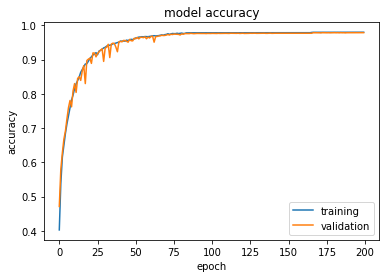

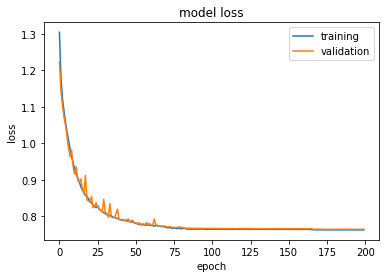

In [20]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot([a.cpu() for a in acc_hist[0]])
plt.plot([a.cpu() for a in acc_hist[1]])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# Save the model

In [21]:
model_path = RESEARCH_WORK_PATH + 'models/multimodal_5s_0.5shift_200epoch_LSTM_kernel_3.pth'
torch.save(model.state_dict(), model_path)